# Bottle of Wine Price Prediction by Group 12

Description: Let's try to predict the price of a bottle of wine based on a collection of over one hundred thousand reviews and other product features.

Evaluation: Root Mean Squared Error (RMSE).  
RMSE = sqrt (mean ((predicted-true) ^ 2))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# show all columns
pd.set_option('display.max_columns', None)

%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define scoring metric
def rmse_score(y_actual, y_predicted):
    return np.sqrt(np.mean(np.square(y_actual - y_predicted)))

In [3]:
# import train and test data.
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv", index_col='id')

In [4]:
train_df.columns, test_df.columns

(Index(['country', 'description', 'designation', 'points', 'price', 'province',
        'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
        'variety', 'winery', 'id'],
       dtype='object'),
 Index(['index', 'country', 'description', 'designation', 'points', 'price',
        'province', 'region_1', 'region_2', 'taster_name',
        'taster_twitter_handle', 'title', 'variety', 'winery'],
       dtype='object'))

In [5]:
# drop id columns (not necessary)
train_df.drop(columns=["id"], inplace=True)
test_df.drop(columns=["index", "price"], inplace=True)

# Column of train one more than test because of the price column
train_df.shape, test_df.shape

((175000, 13), (83210, 12))

In [6]:
train_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
country,Portugal,France,France,US,US,Spain,France,Italy,US,Italy
description,This is a fine rich balanced wine. It has ripe...,"A solid, chunky wine, with a structure that is...","This is powerful and concentrated, with the hi...","Rich, ripe and oaky, this Petite Sirah charms ...",This wine is a unique in the state blend and f...,This brut nature is citric and bubbly on the p...,"A ripe wine that has red-berry fruits, slices ...",From one of Sicily's most beautiful and promis...,This wine plays close to the edge of overripe-...,This basic Prosecco is perfectly quaffable tha...
designation,Vila Santa Reserva,NaN,NaN,Thompson Vineyard,McKinley Springs Vineyard,Brut Nature Reserva,Cuvée Prestige,Baccante,NaN,Lellè Extra Dry
points,88.8709,88.0417,94.085,89.8698,89.0177,83.1187,88.3205,85.1735,85.9087,81.9295
price,20,28,130,34,24,13,35,42,38,14
province,Alentejano,Bordeaux,Bordeaux,California,Washington,Catalonia,Bordeaux,Sicily & Sardinia,California,Veneto
region_1,NaN,Lalande de Pomerol,Saint-Émilion,Santa Barbara County,Horse Heaven Hills,Cava,Bordeaux Supérieur,Sicilia,Russian River Valley,Prosecco
region_2,NaN,NaN,NaN,Central Coast,Columbia Valley,NaN,NaN,NaN,Sonoma,NaN
taster_name,NaN,NaN,NaN,NaN,Sean P. Sullivan,Michael Schachner,Roger Voss,NaN,Virginie Boone,NaN
taster_twitter_handle,NaN,NaN,NaN,NaN,@wawinereport,@wineschach,@vossroger,NaN,@vboone,NaN


In [7]:
# Check if similar amount of null values in train and test columns
a = train_df.drop(columns=["price"]).count()
b = test_df.count()
pd.DataFrame({"train_data (17500)": a, "test_data (83210)": b})

,train_data (17500),test_data (83210)
country,174953,83193
description,175000,83210
designation,122734,58386
points,175000,83210
province,174953,83193
region_1,146466,69327
region_2,75394,35602
taster_name,65509,30970
taster_twitter_handle,62190,29369
title,82189,38786


In [8]:
# Check data types
train_df.info(),  test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 13 columns):
country                  174953 non-null object
description              175000 non-null object
designation              122734 non-null object
points                   175000 non-null float64
price                    175000 non-null float64
province                 174953 non-null object
region_1                 146466 non-null object
region_2                 75394 non-null object
taster_name              65509 non-null object
taster_twitter_handle    62190 non-null object
title                    82189 non-null object
variety                  174999 non-null object
winery                   175000 non-null object
dtypes: float64(2), object(11)
memory usage: 17.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 83210 entries, 0 to 83209
Data columns (total 12 columns):
country                  83193 non-null object
description              83210 non-null object
designatio

(None, None)

Observations: Only one numeric predictor; Many columns with null values

In [9]:
# % of  NULL values
null_values = [train_df[x].isnull().sum()/1750 for x in train_df.columns ]
pd.DataFrame(null_values, index=train_df.columns, columns=["% Null Values in Train Set"])

,% Null Values in Train Set
country,0.026857
description,0.000000
designation,29.866286
points,0.000000
price,0.000000
province,0.026857
region_1,16.305143
region_2,56.917714
taster_name,62.566286
taster_twitter_handle,64.462857


Observation: Designation, regions, tasters, title have sparse vectors

In [10]:
train_df.describe()

,points,price
count,175000.000000,175000.000000
mean,88.083987,34.304400
std,3.157001,38.398146
min,79.636128,4.000000
25%,85.971283,16.000000
50%,87.981631,25.000000
75%,90.085631,40.000000
max,100.220603,2500.000000


Observation: Points range from 79 to 100(approx), with a mean of 88. Price has a large range and probably skewed

### Imputation / Dealing with null values

Missing: **Variety**  
Missing variety can be found in title

In [11]:
train_df[train_df['variety'].isnull()]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
86403,Chile,"A chalky, dusty mouthfeel nicely balances this...",NaN,88.046742,17.0,Maipo Valley,NaN,NaN,NaN,NaN,Carmen 1999 (Maipo Valley),NaN,Carmen


In [12]:
variety = train_df[(train_df['province'] == 'Maipo Valley') & (train_df['winery'] == 'Carmen')]['variety'].mode()[0]
print(variety)

train_df['variety'][86403] = variety

CABERNET SAUVIGNON


Missing: **Designation**  
Information of 'designation' is contained in 'title'

In [13]:
import re

Missing: **Region 1**

In [14]:
train_df[['region_1', 'title']].head(10)

,region_1,title
0,NaN,NaN
1,Lalande de Pomerol,NaN
2,Saint-Émilion,NaN
3,Santa Barbara County,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...
4,Horse Heaven Hills,Syncline 2016 McKinley Springs Vineyard Rosé (...
5,Cava,Mas Fi NV Brut Nature Reserva Sparkling (Cava)
6,Bordeaux Supérieur,Château Tayet 2014 Cuvée Prestige (Bordeaux S...
7,Sicilia,NaN
8,Russian River Valley,Matrix 2013 Pinot Noir (Russian River Valley)
9,Prosecco,NaN


In [15]:
# Extract region from title
def get_regions(string):
    if type(string) is str:
        try:
            detached_string = re.search(r'\((.*?)\)', string).group(1).strip()
            return detached_string
        except:
            return np.nan
    else: return np.nan
train_df["new_region1"]= train_df["title"].apply(get_regions)
test_df["new_region1"]= test_df["title"].apply(get_regions)

train_df["new_region1"].isna().sum(), test_df["new_region1"].isna().sum()

(98630, 47185)

In [16]:
# Check current number of NA values
train_df["region_1"].isna().sum(), train_df["new_region1"].isna().sum()

(28534, 98630)

In [17]:
train_df.region_1.fillna(train_df.new_region1, inplace=True)
test_df.region_1.fillna(test_df.new_region1, inplace=True)
del train_df['new_region1']
del test_df['new_region1']

#Check number after fillna
train_df["region_1"].isna().sum()

15615

In [18]:
train_df['region_1'].sort_values()

25966     Abruzzo
169633    Abruzzo
147615    Abruzzo
30915     Abruzzo
95298     Abruzzo
           ...   
174913        NaN
174921        NaN
174945        NaN
174961        NaN
174962        NaN
Name: region_1, Length: 175000, dtype: object

### Feature Engineering

### Points

Source: https://towardsdatascience.com/wine-ratings-prediction-using-machine-learning-ce259832b321  
https://towardsdatascience.com/predicting-wine-quality-using-text-reviews-8bddaeb5285d  
Range of Points is 79 to 101  
1 -> Points 80 to 82 (Acceptable wines)  
2 -> Points 83 to 86 (Good wines)  
3 -> Points 87 to 89 (Very Good wines)  
4 -> Points 90 to 93 (Excellent wines)  
5 -> Points 94 to 101 (Superb wines)  

In [19]:
def choose_points(point):
    if   point >= 94: return 5
    elif point >= 90: return 4
    elif point >= 87: return 3
    elif point >= 83: return 2
    else: return 1

train_df['ratings'] = train_df['points'].apply(choose_points)
test_df['ratings'] = test_df['points'].apply(choose_points)

# train_df.drop(columns=['points'], inplace=True)
# test_df.drop(columns=['points'], inplace=True)

In [20]:
train_df[['points', 'price']].corr()

,points,price
points,1.000000,0.443276
price,0.443276,1.000000


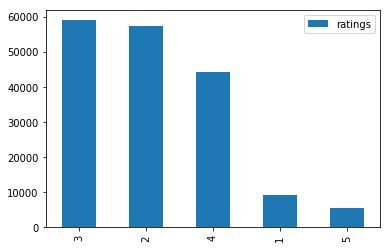

In [21]:
train_df['ratings'].value_counts().to_frame().plot(kind='bar')

Observation: Imbalanced data cos some ratings have low data

### Countries

Observation: On average, Northern europe and Western wines are more expensive

### Tasters

Text(0, 0.5, 'Ratings')

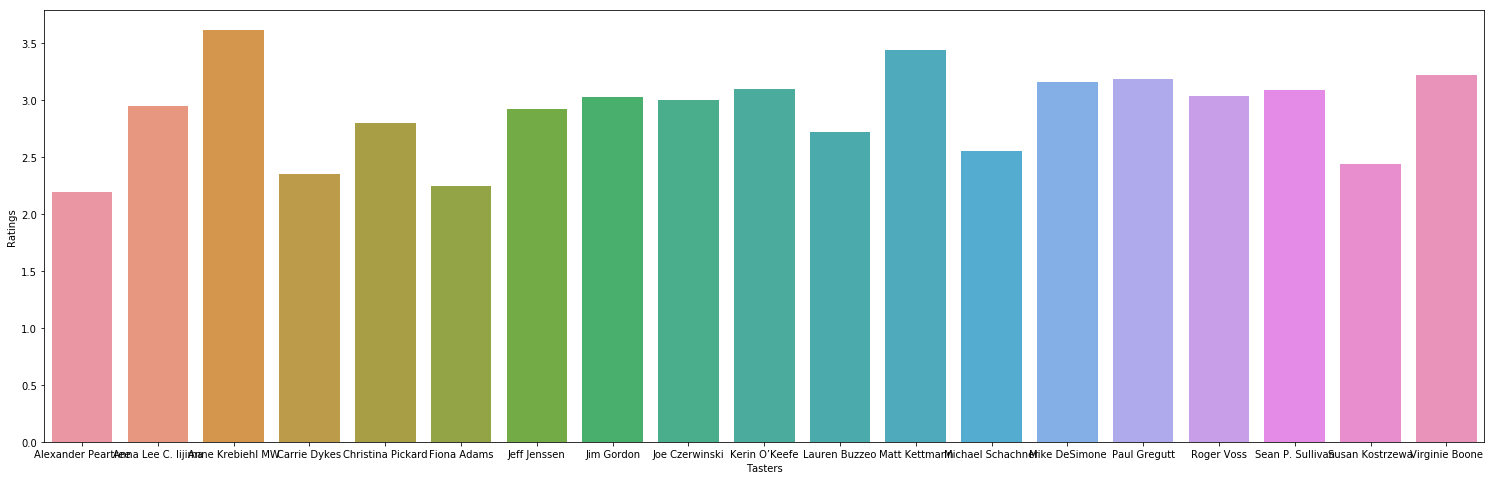

In [22]:
tasters = train_df.groupby('taster_name').mean()['ratings'].to_frame().reset_index()

fig = plt.figure(figsize=(20,6))
ax = fig.add_axes([0, 0, 1, 1])

sns.barplot("taster_name", "ratings", data=tasters, ax=ax)

ax.set_xlabel('Tasters')
ax.set_ylabel('Ratings')

Observation: Not much bias in their ratings

### Twitter Handle

In [23]:
# Create column to check if user has twitter handle
train_df['has_twit_handle'] = train_df['taster_twitter_handle'].notnull()
test_df['has_twit_handle'] = test_df['taster_twitter_handle'].notnull()

# Convert bool to numeric
train_df['has_twit_handle'] = train_df['has_twit_handle'].astype(int)
test_df['has_twit_handle'] = test_df['has_twit_handle'].astype(int)

In [24]:
train_df['has_twit_handle'].head()

0    0
1    0
2    0
3    0
4    1
Name: has_twit_handle, dtype: int64

### Title

In [25]:
# Extract year from title
train_df['title'].fillna(value='None', inplace=True)

def extract_year(string):
    if type(string) is str:
        digit = [int(s) for s in string.split() if s.isdigit()]
        if digit and len(str(digit[0])) == 4:
            return digit[0]
        else: return np.nan
    return np.nan

train_df['title_year'] = train_df['title'].apply(extract_year)
test_df['title_year'] = test_df['title'].apply(extract_year)

train_df['title'].replace({'None':np.nan}, inplace=True)

In [26]:
train_df['title_year'].value_counts()

2013.0    10229
2012.0     9951
2014.0     9934
2011.0     7674
2010.0     7494
          ...  
1947.0        1
1945.0        1
1934.0        1
1927.0        1
1070.0        1
Name: title_year, Length: 79, dtype: int64

### Encoding

In [27]:
# Find number of unique values in each column
train_df.nunique(), train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 16 columns):
country                  174953 non-null object
description              175000 non-null object
designation              122734 non-null object
points                   175000 non-null float64
price                    175000 non-null float64
province                 174953 non-null object
region_1                 159385 non-null object
region_2                 75394 non-null object
taster_name              65509 non-null object
taster_twitter_handle    62190 non-null object
title                    82189 non-null object
variety                  175000 non-null object
winery                   175000 non-null object
ratings                  175000 non-null int64
has_twit_handle          175000 non-null int64
title_year               78991 non-null float64
dtypes: float64(3), int64(2), object(11)
memory usage: 21.4+ MB


(country                      45
 description              123811
 designation               37931
 points                   175000
 price                       387
 province                    468
 region_1                   1619
 region_2                     18
 taster_name                  19
 taster_twitter_handle        15
 title                     77411
 variety                     706
 winery                    16968
 ratings                       5
 has_twit_handle               2
 title_year                   79
 dtype: int64, None)

In [28]:
# !pip install category_encoders
import category_encoders as ce

# https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
target_df = train_df['price']
train_df.drop(columns=['price'], inplace=True)

In [29]:
train_df.shape, test_df.shape

((175000, 15), (83210, 15))

In [30]:
train_df.nunique()

country                      45
description              123811
designation               37931
points                   175000
province                    468
region_1                   1619
region_2                     18
taster_name                  19
taster_twitter_handle        15
title                     77411
variety                     706
winery                    16968
ratings                       5
has_twit_handle               2
title_year                   79
dtype: int64

In [31]:
t_encoder = ce.ordinal.OrdinalEncoder(cols=['designation', 'province',
        'region_1', 'title', 'variety', 'winery'])
t_encoder.fit(train_df, target_df)
train_df_encoded = t_encoder.transform(train_df)
test_df_encoded = t_encoder.transform(test_df)

In [32]:
one_encoder = ce.OneHotEncoder(cols=['country','region_2', 'title_year', 'taster_name', 'taster_twitter_handle'], use_cat_names=True)
train_df_encoded = one_encoder.fit_transform(train_df_encoded)
test_df_encoded = one_encoder.transform(test_df_encoded)

In [33]:
train_df_encoded.shape, test_df_encoded.shape

((175000, 191), (83210, 191))

In [34]:
train_df_encoded.head()

,country_Portugal,country_France,country_US,country_Spain,country_Italy,country_Chile,country_Argentina,country_Australia,country_Greece,country_Austria,country_New Zealand,country_South Africa,country_Slovenia,country_Germany,country_Bulgaria,country_Romania,country_Canada,country_Israel,country_Moldova,country_England,country_India,country_Bosnia and Herzegovina,country_Cyprus,country_Croatia,country_Hungary,country_Lithuania,country_Brazil,country_nan,country_Morocco,country_Mexico,country_China,country_Uruguay,country_Turkey,country_Ukraine,country_Lebanon,country_South Korea,country_Georgia,country_Peru,country_Japan,country_Switzerland,country_Macedonia,country_Luxembourg,country_Czech Republic,country_Serbia,country_Slovakia,country_Armenia,description,designation,points,province,region_1,region_2_nan,region_2_Central Coast,region_2_Columbia Valley,region_2_Sonoma,region_2_Finger Lakes,region_2_Willamette Valley,region_2_Napa-Sonoma,region_2_Napa,region_2_Southern Oregon,region_2_California Other,region_2_Sierra Foothills,region_2_Oregon Other,region_2_Central Valley,region_2_North Coast,region_2_Mendocino/Lake Counties,region_2_Long Island,region_2_Washington Other,region_2_South Coast,region_2_New York Other,taster_name_nan,taster_name_Sean P. Sullivan,taster_name_Michael Schachner,taster_name_Roger Voss,taster_name_Virginie Boone,taster_name_Joe Czerwinski,taster_name_Matt Kettmann,taster_name_Kerin O’Keefe,taster_name_Susan Kostrzewa,taster_name_Anne Krebiehl MW,taster_name_Paul Gregutt,taster_name_Lauren Buzzeo,taster_name_Jim Gordon,taster_name_Anna Lee C. Iijima,taster_name_Alexander Peartree,taster_name_Jeff Jenssen,taster_name_Mike DeSimone,taster_name_Carrie Dykes,taster_name_Fiona Adams,taster_name_Christina Pickard,taster_twitter_handle_nan,taster_twitter_handle_@wawinereport,taster_twitter_handle_@wineschach,taster_twitter_handle_@vossroger,taster_twitter_handle_@vboone,taster_twitter_handle_@JoeCz,taster_twitter_handle_@mattkettmann,taster_twitter_handle_@kerinokeefe,taster_twitter_handle_@suskostrzewa,taster_twitter_handle_@AnneInVino,taster_twitter_handle_@paulgwine,taster_twitter_handle_@laurbuzz,taster_twitter_handle_@gordone_cellars,taster_twitter_handle_@worldwineguys,taster_twitter_handle_@bkfiona,taster_twitter_handle_@winewchristina,title,variety,winery,ratings,has_twit_handle,title_year_nan,title_year_2010.0,title_year_2016.0,title_year_2014.0,title_year_2013.0,title_year_2005.0,title_year_2011.0,title_year_2015.0,title_year_2007.0,title_year_2009.0,title_year_2012.0,title_year_2004.0,title_year_1995.0,title_year_2008.0,title_year_2006.0,title_year_2003.0,title_year_2000.0,title_year_2001.0,title_year_1997.0,title_year_1998.0,title_year_1852.0,title_year_1999.0,title_year_2002.0,title_year_1996.0,title_year_1992.0,title_year_1990.0,title_year_1875.0,title_year_1994.0,title_year_1492.0,title_year_1986.0,title_year_1150.0,title_year_1877.0,title_year_1847.0,title_year_1983.0,title_year_1991.0,title_year_1898.0,title_year_7200.0,title_year_1988.0,title_year_1872.0,title_year_1965.0,title_year_1850.0,title_year_2017.0,title_year_1860.0,title_year_1927.0,title_year_1821.0,title_year_1989.0,title_year_1868.0,title_year_1957.0,title_year_1978.0,title_year_1904.0,title_year_1976.0,title_year_1882.0,title_year_1987.0,title_year_1969.0,title_year_1929.0,title_year_1967.0,title_year_1980.0,title_year_1993.0,title_year_1621.0,title_year_1845.0,title_year_1961.0,title_year_1848.0,title_year_1945.0,title_year_1952.0,title_year_1070.0,title_year_1870.0,title_year_1637.0,title_year_1856.0,title_year_1985.0,title_year_1607.0,title_year_1963.0,title_year_1968.0,title_year_1934.0,title_year_1789.0,title_year_1984.0,title_year_1947.0,title_year_1973.0,title_year_3000.0,title_year_1919.0,title_year_1982.0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,This is a fine rich balanced wine. It has ripe...,1,88.870874,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

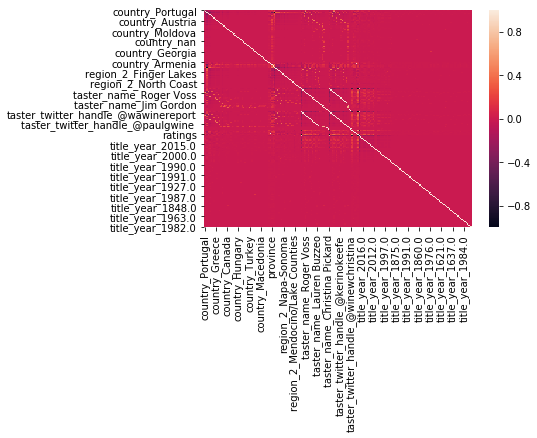

In [35]:
sns.heatmap(train_df_encoded.corr())

In [36]:
# Find number of words in each description. Naive
train_df_encoded['n_words'] = train_df_encoded['description'].apply(lambda x: len(x.split()))
test_df_encoded['n_words'] = test_df_encoded['description'].apply(lambda x: len(x.split()))
train_df_encoded['n_char'] = train_df_encoded['description'].apply(lambda x: len(x))
test_df_encoded['n_char'] = test_df_encoded['description'].apply(lambda x: len(x))

In [37]:
train_df_encoded.shape, test_df_encoded.shape 

((175000, 193), (83210, 193))

In [38]:
### Create Polynomial Interactions

In [39]:
train_df_encoded.columns

Index(['country_Portugal', 'country_France', 'country_US', 'country_Spain',
       'country_Italy', 'country_Chile', 'country_Argentina',
       'country_Australia', 'country_Greece', 'country_Austria',
       ...
       'title_year_1934.0', 'title_year_1789.0', 'title_year_1984.0',
       'title_year_1947.0', 'title_year_1973.0', 'title_year_3000.0',
       'title_year_1919.0', 'title_year_1982.0', 'n_words', 'n_char'],
      dtype='object', length=193)

### Description

In [40]:
from sklearn.feature_extraction import text

In [41]:
train_desc = train_df[['description']]
test_desc = test_df[['description']]

all_desc = pd.concat([train_desc, test_desc], ignore_index=True)
all_desc.head()

,description
0,This is a fine rich balanced wine. It has ripe...
1,"A solid, chunky wine, with a structure that is..."
2,"This is powerful and concentrated, with the hi..."
3,"Rich, ripe and oaky, this Petite Sirah charms ..."
4,This wine is a unique in the state blend and f...


In [42]:
all_desc = pd.DataFrame(all_desc)

In [43]:
# Find most frequently occuring words and their count or percentage
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

# set seaborn style 
sns.set(style="whitegrid")

stopwords = set(stopwords.words('english'))
# Detokenizer combines tokenized elements
detokenizer = TreebankWordDetokenizer()

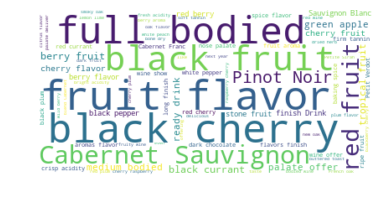

In [69]:
# Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(desc for desc in all_desc['description'])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=100, 
                      background_color="white",
                      stopwords=stopwords
                     ).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("first_review.png")

Observation: Wine and flavors are the most occuring words in the corpus of description

In [44]:
import string
from nltk.tokenize import sent_tokenize, word_tokenize
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stopwords, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

Sentiment Analysis of Description

TD-idf

In [45]:
# Convert text to bag of words
from sklearn.feature_extraction import text
bow_transform = text.CountVectorizer(stop_words=stopwords, 
                                     max_df=0.8, 
                                     min_df=7, 
                                     max_features=200,
                                     tokenizer=tokenize
                                    )
all_description = np.append(train_desc.values, test_desc.values)
all_bow = bow_transform.fit_transform(all_description)
# train_bow = bow_transform.fit_transform()
# test_bow = bow_transform.transform(test_df['description'])
len(bow_transform.vocabulary_)

200

In [46]:
tfidf_trfm = text.TfidfTransformer()
tfidf = tfidf_trfm.fit_transform(all_bow)

In [47]:
new_cols = bow_transform.get_feature_names()
new_cols[0:10]

['acidity',
 'age',
 'aging',
 'alcohol',
 'almost',
 'along',
 'alongside',
 'also',
 'apple',
 'apricot']

In [49]:
df_desc = pd.DataFrame(tfidf.toarray(), columns=new_cols)
df_desc.shape

(258210, 200)

In [50]:
train_df_encoded.rename(columns = {"winery": "winery_col", 
                     "variety":"variety_col"}, 
                                 inplace = True)
test_df_encoded.rename(columns = {"winery": "winery_col", 
                     "variety":"variety_col"}, 
                                 inplace = True)

train_df_desc = pd.DataFrame(tfidf[0:175000].toarray(), columns=new_cols)
test_df_desc = pd.DataFrame(tfidf[175000: ].toarray(), columns=new_cols)

# Combine dataframe
train_df_concat = train_df_encoded.join(train_df_desc)
test_df_concat =test_df_encoded.join(test_df_desc)

train_df_concat.shape, test_df_concat.shape

((175000, 393), (83210, 393))

In [52]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 20

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(all_bow)


In [53]:
tf_feature_names = bow_transform.get_feature_names()

In [54]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print( "Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
#display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
juicy fruits young high intense barrel tight core wine minerality
Topic 1:
wine drink acidity ripe fruits fruit tannins still rich great
Topic 2:
flavors cherry raspberry good wine little light mouth pretty dry
Topic 3:
slightly yet best alcohol nice also much wines come like
Topic 4:
black wine fruit shows well pepper balance spicy structure tannins
Topic 5:
herbal bit cherries smoky round complexity character drink flavors wine
Topic 6:
lemon flavors creamy lime chardonnay acidity pineapple vanilla crisp toast
Topic 7:
finish palate nose long aromas flavors note melon feels lead
Topic 8:
red berry aromas flavors cherry plum easy bright tastes fruit
Topic 9:
years tobacco tannic big age time one bottle vintage wine
Topic 10:
blend cabernet sauvignon merlot flavor blanc green balanced fruit soft
Topic 11:
black tannins currant licorice firm leather delivers baked along fine
Topic 12:
fresh apple citrus white fruit aromas flavors acidity palate peach
Topic 13:
pinot mouthfeel h

In [55]:
lda_arr = lda.transform(all_bow)

In [56]:
# column names
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda.components_)

# Assign Column and Index
df_topic_keywords.columns = bow_transform.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,acidity,age,aging,alcohol,almost,along,alongside,also,apple,apricot,aromas,attractive,baked,balance,balanced,barrel,berry,best,big,bit,bitter,black,blackberries,blackberry,blanc,blend,bodied,bottle,bright,cabernet,cassis,cedar,character,chardonnay,cherries,cherry,chocolate,cinnamon,citrus,clean,clove,coffee,cola,color,come,complex,complexity,concentrated,core,creamy,crisp,currant,dark,delicious,delivers,dense,dried,drink,drinking,dry,earth,earthy,easy,edge,elegant,enough,feel,feels,fine,finish,finishes,firm,flavor,flavors,floral,fresh,freshness,fruit,fruits,fruity,full,give,good,grapefruit,grapes,great,green,hard,herb,herbal,herbs,high,hint,hints,honey,intense,jammy,juicy,lead,leather,lemon,licorice,light,like,lime,little,lively,long,lush,made,make,medium,melon,merlot,mineral,minerality,mocha,mouth,mouthfeel,much,new,nice,noir,nose,note,notes,oak,oaky,offers,one,opens,orange,palate,peach,pear,pepper,pineapple,pinot,plenty,plum,pretty,quite,raspberry,ready,red,refreshing,rich,richness,ripe,round,sauvignon,savory,scents,showing,shows,silky,simple,slightly,smoke,smoky,smooth,soft,solid,spice,spices,spicy,still,stone,strawberry,structure,structured,style,sweet,syrah,tannic,tannins,tart,tastes,texture,tight,time,toast,toasty,tobacco,touch,tropical,vanilla,vineyard,vintage,weight,well,white,wild,wine,wines,wood,years,yellow,yet,young
Topic0,3144.279569,0.050000,986.986692,0.050000,0.05,1736.288232,0.05,0.050000,0.05,0.05,0.050000,0.050000,0.05,0.050000,1648.579266,6278.126398,0.340104,0.050000,0.05,0.050000,0.05,0.05000,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.050000,4916.99239,0.05,0.050000,0.05,0.050000,355.517104,0.050000,0.050000,0.05,4.039946,0.050000,0.050000,0.05,0.050000,0.05,0.05,979.066498,0.05,0.05,0.05,0.050000,0.050000,0.05,0.119341,2681.020181,57.456327,0.05,0.05,0.050000,2536.821642,9092.933510,0.050000,0.050000,0.050000,0.050000,0.05,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,8578.965804,0.05,0.050000,0.05,7578.02443,0.050000,15374.498017,0.05,0.05,0.05,0.05,0.050000,0.050000,0.05,0.050000,0.050000,0.05,0.05,0.050000,0.050000,0.05,0.05,0.05,0.050000,3756.983472,0.05,0.050000,0.05,0.05000,0.05,0.050000,0.05,0.05,0.05,0.05,0.050000,0.05,0.05,0.050000,0.05,0.05,0.050000,0.05,0.05,0.050000,0.05,0.05,0.050000,0.050000,0.050000,0.050000,0.050000,0.0500,172.283902,0.05,0.073648,0.050000,137.930933,0.05,0.05,0.05,0.05,0.05,0.050000,0.050000,0.05,0.050000,0.050000,0.05,0.05,0.396618,0.05,0.050000,0.05,0.050000,0.050000,0.05,0.050000,0.050000,0.05000,0.05,0.050000,0.05,0.05,1013.630307,1395.279006,0.05,0.050000,5886.053555,0.050000,0.050000,0.05,0.05,0.050000,0.050000,0.050000,0.05,1208.920471,0.05,0.050000,0.05,0.05,3782.698290,0.050000,0.050073,0.050813,0.05,0.050000,8754.250637
Topic1,19829.133184,3951.826934,8132.144675,0.050000,0.05,0.050000,0.05,3844.643710,0.05,0.05,0.050000,6117.317494,0.05,0.050000,7151.509678,0.050000,0.050000,0.050000,0.05,0.050000,0.05,0.05000,0.05,0.05,0.05,0.05,0.05,0.05,2446.246432,0.05,0.050000,0.050000,8932.560345,0.05,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.050000,0.050000,0.05,0.05,2524.695579,0.05000,0.05,4199.690797,0.05,0.050000,3941.022773,0.050000,0.050000,0.05,23697.029106,0.050000,5184.823346,0.05,0.050000,0.05,0.05,0.050000,0.05,0.05,0.05,4894.104967,0.050000,0.05,5168.010536,0.050000,5602.301415,0.05,0.05,2775.587311,12081.871159,12558.991593,7953.135019,5782.163014,5759.621644,0.050000,0.05,0.05,10160.124096,0.05,0.05,0.05,0.05,0.05,0.050000,0.05,651.100848,0.05,0.05000,0.050000,0.050000,0.05,0.05,0.05,0.05,0.050000,0.050000,0.05,0.050000,1009.843798,0.05,0.05,0.050000,0.050000,0.05,0.05,0.05,2991.067851,0.050000,0.05,0.050000,0.05,0.05000,0.05,0.050000,0.05,0.05,0.05,0.05,0.050000,0.05,0.05,0.050000,0.05,0.05,0.050000,0.05,0.05,0.050000,0.05,0.05,0.050000,0.050000,0.050000,0.050000,0.050000,7713.4437,6227.012817,0.05,10656.992200,6562.177482,17240.03158

In [57]:
lda_arr.shape

(258210, 20)

In [58]:
df_desc = pd.DataFrame(lda_arr, columns=topicnames)
df_desc.shape

(258210, 20)

In [59]:
train_df_concat.shape, test_df_concat.shape

((175000, 393), (83210, 393))

In [60]:
train_df_lda = df_desc[0:175000]
test_df_lda = df_desc[175000: ].reset_index(drop=True)

# Combine dataframe
train_df_final = train_df_concat.join(train_df_lda)
test_df_final =test_df_concat.join(test_df_lda)

train_df_final.shape, test_df_final.shape

((175000, 413), (83210, 413))

In [61]:
del train_df_final['description']
del test_df_final['description']
#del train_df_concat['clean_comment']
#del test_df_concat['clean_comment']

In [62]:
train_df_final.shape, test_df_final.shape

((175000, 412), (83210, 412))

In [63]:
test_df_final.head()

,country_Portugal,country_France,country_US,country_Spain,country_Italy,country_Chile,country_Argentina,country_Australia,country_Greece,country_Austria,country_New Zealand,country_South Africa,country_Slovenia,country_Germany,country_Bulgaria,country_Romania,country_Canada,country_Israel,country_Moldova,country_England,country_India,country_Bosnia and Herzegovina,country_Cyprus,country_Croatia,country_Hungary,country_Lithuania,country_Brazil,country_nan,country_Morocco,country_Mexico,country_China,country_Uruguay,country_Turkey,country_Ukraine,country_Lebanon,country_South Korea,country_Georgia,country_Peru,country_Japan,country_Switzerland,country_Macedonia,country_Luxembourg,country_Czech Republic,country_Serbia,country_Slovakia,country_Armenia,designation,points,province,region_1,region_2_nan,region_2_Central Coast,region_2_Columbia Valley,region_2_Sonoma,region_2_Finger Lakes,region_2_Willamette Valley,region_2_Napa-Sonoma,region_2_Napa,region_2_Southern Oregon,region_2_California Other,region_2_Sierra Foothills,region_2_Oregon Other,region_2_Central Valley,region_2_North Coast,region_2_Mendocino/Lake Counties,region_2_Long Island,region_2_Washington Other,region_2_South Coast,region_2_New York Other,taster_name_nan,taster_name_Sean P. Sullivan,taster_name_Michael Schachner,taster_name_Roger Voss,taster_name_Virginie Boone,taster_name_Joe Czerwinski,taster_name_Matt Kettmann,taster_name_Kerin O’Keefe,taster_name_Susan Kostrzewa,taster_name_Anne Krebiehl MW,taster_name_Paul Gregutt,taster_name_Lauren Buzzeo,taster_name_Jim Gordon,taster_name_Anna Lee C. Iijima,taster_name_Alexander Peartree,taster_name_Jeff Jenssen,taster_name_Mike DeSimone,taster_name_Carrie Dykes,taster_name_Fiona Adams,taster_name_Christina Pickard,taster_twitter_handle_nan,taster_twitter_handle_@wawinereport,taster_twitter_handle_@wineschach,taster_twitter_handle_@vossroger,taster_twitter_handle_@vboone,taster_twitter_handle_@JoeCz,taster_twitter_handle_@mattkettmann,taster_twitter_handle_@kerinokeefe,taster_twitter_handle_@suskostrzewa,taster_twitter_handle_@AnneInVino,taster_twitter_handle_@paulgwine,taster_twitter_handle_@laurbuzz,taster_twitter_handle_@gordone_cellars,taster_twitter_handle_@worldwineguys,taster_twitter_handle_@bkfiona,taster_twitter_handle_@winewchristina,title,variety_col,winery_col,ratings,has_twit_handle,title_year_nan,title_year_2010.0,title_year_2016.0,title_year_2014.0,title_year_2013.0,title_year_2005.0,title_year_2011.0,title_year_2015.0,title_year_2007.0,title_year_2009.0,title_year_2012.0,title_year_2004.0,title_year_1995.0,title_year_2008.0,title_year_2006.0,title_year_2003.0,title_year_2000.0,title_year_2001.0,title_year_1997.0,title_year_1998.0,title_year_1852.0,title_year_1999.0,title_year_2002.0,title_year_1996.0,title_year_1992.0,title_year_1990.0,title_year_1875.0,title_year_1994.0,title_year_1492.0,title_year_1986.0,title_year_1150.0,title_year_1877.0,title_year_1847.0,title_year_1983.0,title_year_1991.0,title_year_1898.0,title_year_7200.0,title_year_1988.0,title_year_1872.0,title_year_1965.0,title_year_1850.0,title_year_2017.0,title_year_1860.0,title_year_1927.0,title_year_1821.0,title_year_1989.0,title_year_1868.0,title_year_1957.0,title_year_1978.0,title_year_1904.0,title_year_1976.0,title_year_1882.0,title_year_1987.0,title_year_1969.0,title_year_1929.0,title_year_1967.0,title_year_1980.0,title_year_1993.0,title_year_1621.0,title_year_1845.0,title_year_1961.0,title_year_1848.0,title_year_1945.0,title_year_1952.0,title_year_1070.0,title_year_1870.0,title_year_1637.0,title_year_1856.0,title_year_1985.0,title_year_1607.0,title_year_1963.0,title_year_1968.0,title_year_1934.0,title_year_1789.0,title_year_1984.0,title_year_1947.0,title_year_1973.0,title_year_3000.0,title_year_1919.0,title_year_1982.0,n_words,n_char,acidity,age,aging,alcohol,almost,along,alongside,also,apple,apricot,aromas,attractive,baked,balance,balanced,barrel,berry,best,big,bit,bitter,black,blackberries,blackberry,blanc,blend,bodied,bottle,bright

In [64]:
# Save data fro model
# Saving to pickle file  
train_df_final.to_pickle("LDA_data/train_df.pkl")
test_df_final.to_pickle("LDA_data/test_df.pkl")
target_df.to_pickle("LDA_data/target_df.pkl")

In [65]:
all_desc.to_pickle("LDA_data/all_desc.pkl")

In [ ]:
# To unpiclke
# train_df = pd.read_pickle("data/train_df.pkl")
# test_df = pd.read_pickle("data/test_df.pkl")
# target_df = pd.read_pickle("data/target_df.pkl")

### Thank You  
### Merci